Applying GenomeDISCO on HiChIP data 
===

Analysis to produce Figure 4

Contact: oursu@stanford.edu

Excerpt from paper:

**3.3 Benchmarking GenomeDISCO on HiChIP data**

We applied GenomeDISCO to a set of H3K27ac HiChIP datasets from (Mumbach et al., 2017), covering 2-3 replicates for 7 cell types (GM12878, HCASMC, K562, My-La and 3 types of T-cells: Naïve, Th17 and Treg). As for Hi-C, we binned the HiChIP reads at a resolution of 50 kb and normalized the contact maps using sqrtvc. We then ran GenomeDISCO on all pairwise comparisons and checked whether biological replicates are deemed more concordant than pairs of samples from different cell types. We found that GenomeDISCO scores correctly separate biological replicates from non-replicates, for the non-T-cell comparisons, using the same parameters as for Hi-C and the same threshold for defining concordance (from Figure 3), suggesting that GenomeDISCO generalizes seamlessly to HiChIP data (Figure 4). We obtained similar results for HiCRep and HiC-Spector. For the comparisons between T-cells, all three methods produced similar scores for both comparisons between biological replicates and those between different types of T-cells, with the biological replicates receiving the highest scores in almost all cases. Using the thresholds of concordance derived for Hi-C, we find that for GenomeDISCO, T-cell related comparisons pass the threshold above a sequencing depth of 50 million reads, while HiCRep deems all T-cell comparisons as concordant and HiC-Spector deems a smaller subset as concordant. Overall, we find that GenomeDISCO behaves as expected for HiChIP data, without any modifications to the method.

Analysis
===

In [1]:
require(ggplot2)
require(pheatmap)
require(PRROC)
niceggplot_fullborders=theme(axis.text=element_text(size=20),
                             axis.title=element_text(size=20))
niceggplot=theme(panel.border = element_blank(),panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text=element_text(size=20),axis.title=element_text(size=20))+theme(panel.border = element_blank(), panel.grid.major = element_blank(),panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))

Loading required package: ggplot2
Loading required package: pheatmap
Loading required package: PRROC


Set in stone parameters

In [2]:
DATA_PATH='/ifs/scratch/oursu/paper_2017-12-20'
RES='50000'
SCORES_PATH=paste(DATA_PATH,'/results/HiChIP/res',RES,'.final/compiled_scores',sep='')
PLOTS_PATH=paste(SCORES_PATH,'/plots',sep='')
system(paste('mkdir -p ',PLOTS_PATH))
GENOMEDISCO_THRESHOLD=0.8
HICREP_THRESHOLD=0.82
HICSPECTOR_THRESHOLD=0.27
ADDON=5000000 #add this to seq depth for bioreps, for better visibility
MIN_SCORE=-0.4
MAX_SCORE=1
METADATA_SEQDEPTH_FILE=paste(DATA_PATH,'/HiChIP_data/metadata/metadata.diffcell.samples.res',RES,'.counts',sep='')

Read in scores for GenomeDISCO, HiCRep and HiC-Spector.

In [3]:
read_in_scores=function(f){
    scores=read.table(f)
    colnames(scores)=c('chromosome','m1','m2','score')
    #remove comparisons comparing one dataset to itself
    same=which(as.character(scores[,2])==as.character(scores[,3]))
    if (length(same)>0){
        scores=scores[-same,]
    }
    rownames(scores)=paste(as.character(scores[,2]),as.character(scores[,3]))
    return(scores[,-1])
}

disco=read_in_scores(paste(SCORES_PATH,'/HiChIP.GenomeDISCO.scores.genomewide.txt.gz',sep=''))
hicrep=read_in_scores(paste(SCORES_PATH,'/HiChIP.HiCRep.scores.genomewide.txt.gz',sep=''))
hicspector=read_in_scores(paste(SCORES_PATH,'/HiChIP.HiC-Spector.scores.genomewide.txt.gz',sep=''))

common=intersect(rownames(disco),intersect(rownames(hicrep),rownames(hicspector)))
allscores=data.frame(m1=disco[common,'m1'],m2=disco[common,'m2'],
                 GenomeDISCO=disco[common,'score'],
                 HiCRep=hicrep[common,'score'],
                 HiCSpector=hicspector[common,'score'])
head(allscores)

m1,m2,GenomeDISCO,HiCRep,HiCSpector
HiChIP.GM_H3K27ac.Rep2.reads.gz_res50000,HiChIP.MyLa_H3K27ac.Rep1.reads.gz_res50000,0.6728696,0.5456087,0.1292609
HiChIP.Treg_H3K27ac.Rep3.reads.gz_res50000,HiChIP.Treg_H3K27ac.Rep2.reads.gz_res50000,0.8682174,0.9818261,0.3120435
HiChIP.K562_H3K27ac.Rep2.reads.gz_res50000,HiChIP.Th17_H3K27ac.Rep3.reads.gz_res50000,0.2285652,0.5999565,0.1033913
HiChIP.HCASMC_H3K27ac.Rep1.reads.gz_res50000,HiChIP.Th17_H3K27ac.Rep3.reads.gz_res50000,0.2728696,0.6134783,0.1088261
HiChIP.Naive_H3K27ac.Rep3.reads.gz_res50000,HiChIP.MyLa_H3K27ac.Rep2.reads.gz_res50000,0.2523043,0.3733478,0.0926087
HiChIP.K562_H3K27ac.Rep2.reads.gz_res50000,HiChIP.Naive_H3K27ac.Rep3.reads.gz_res50000,0.2470000,0.5906957,0.1038261


Plot scores as a function of sequencing depth. Color them by whether they are biological replicates or not.

png 
  2

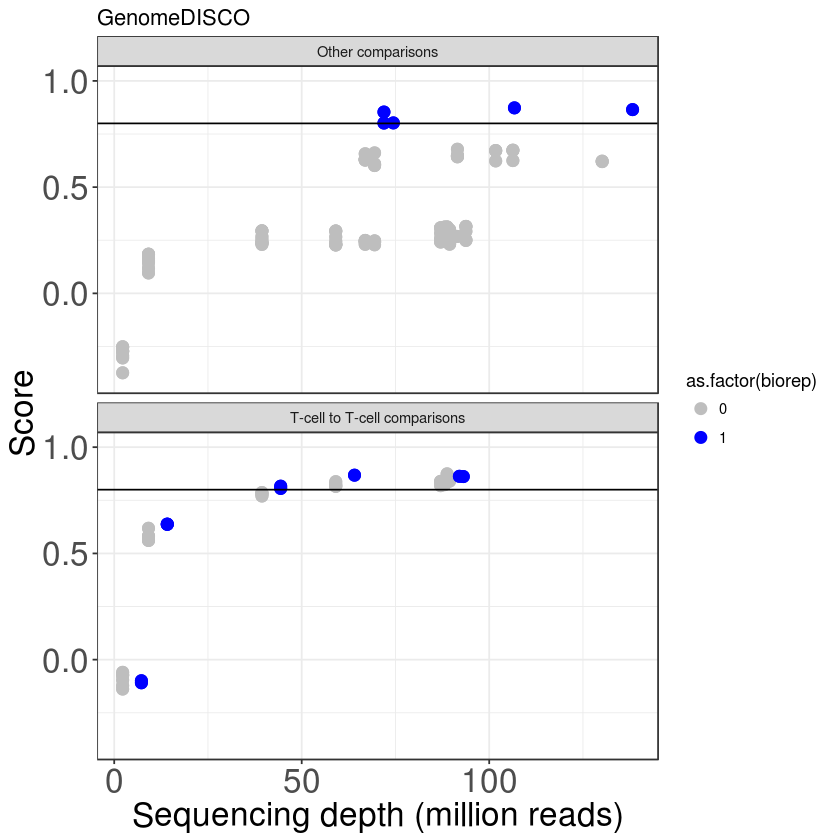

png 
  2

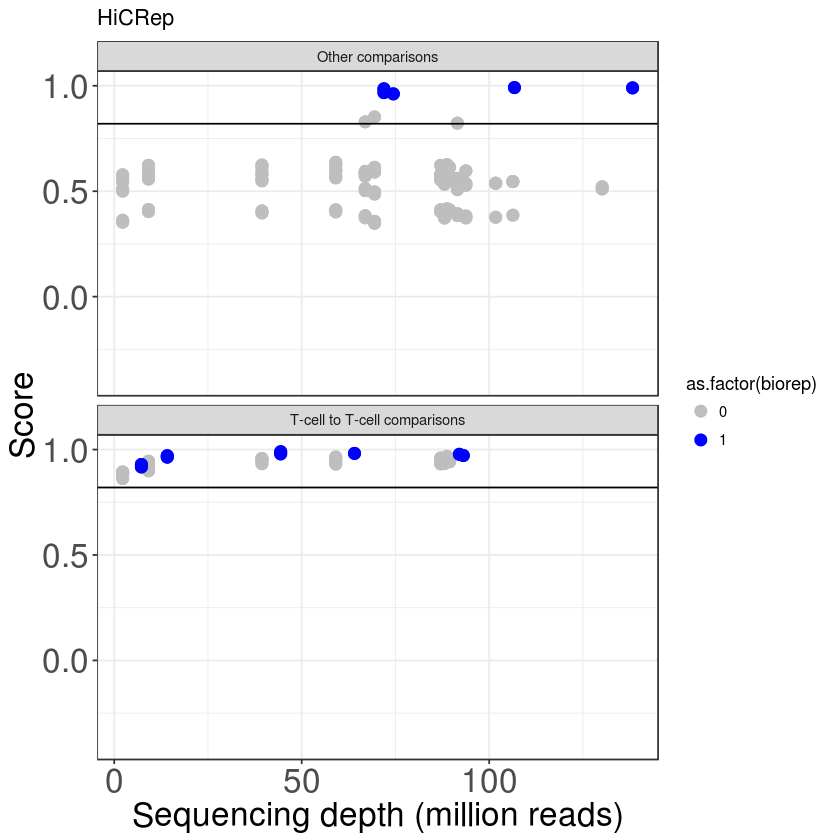

png 
  2

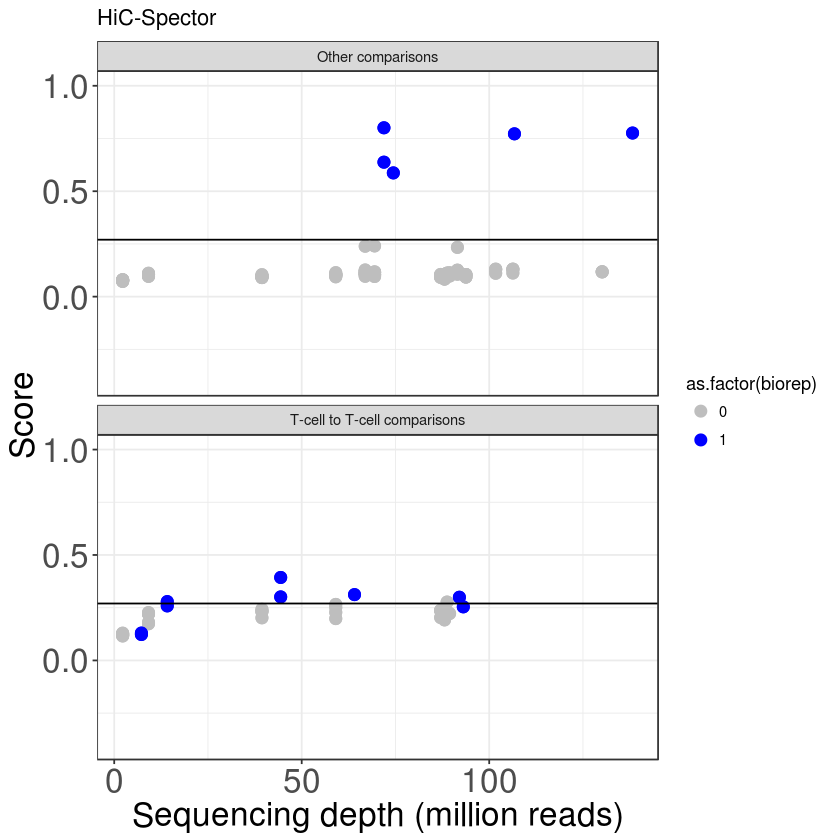

In [4]:
annotate_celltype=function(scores_orig){
n1=gsub('Rep1','',gsub('Rep2','',gsub('Rep3','',as.character(scores_orig[,1]))))
    n2=gsub('Rep1','',gsub('Rep2','',gsub('Rep3','',as.character(scores_orig[,2]))))
    tcells=(grepl('Naive',as.character(scores_orig[,1]))+grepl('T',as.character(scores_orig[,1])))*(grepl('Naive',as.character(scores_orig[,2]))+grepl('T',as.character(scores_orig[,2])))
    tcelltext=rep('Other comparisons',times=length(tcells))
    tcelltext[which(as.numeric(as.character(tcells))==1)]='T-cell to T-cell comparisons'
    scores=data.frame(scores_orig,biorep=1.0*(n1==n2),tcells=tcelltext)
    return(scores)
}

annotate_seqdepth=function(scores,metadata_sequencingdepth_file){
    metadata_seqdepth=read.table(metadata_sequencingdepth_file)
    rownames(metadata_seqdepth)=as.character(metadata_seqdepth[,1])
    scores2=data.frame(scores,s1=metadata_seqdepth[as.character(scores[,'m1']),2],
                      s2=metadata_seqdepth[as.character(scores[,'m2']),2])
    scores3=data.frame(scores2,seqdepth=apply(scores2[,c('s1','s2')],1,min))
    return(scores3)
}

plot_scores_by_seqdepth=function(scores,title,thresh,out,ADDON,min_score,max_score,METADATA_SEQDEPTH_FILE){

    #read and annotate scores
    colnames(scores)[3]='score'
    scores=annotate_celltype(scores)
    scores=annotate_seqdepth(scores,METADATA_SEQDEPTH_FILE)
    scores=scores[order(scores[,'biorep']),]
    
    reps=which(as.character(scores[,'biorep'])=='1')
    scores[reps,'seqdepth']=as.numeric(as.character(scores[reps,'seqdepth']))+ADDON
    
    #plot
    p=ggplot(scores,aes(x=seqdepth/1000000,y=score,color=as.factor(biorep)))+
    facet_wrap(~tcells,ncol=1)+
    theme_bw()+niceggplot_fullborders+geom_point(size=3)+
    scale_color_manual(values = c("gray","blue"))+ggtitle(title)+ylim(min_score,max_score)+
    xlab('Sequencing depth (million reads)')+ylab('Score')+
    geom_hline(yintercept = thresh) 
    print(p)
    
    #save plot
    pdf(out,width=7,height=11)
    print(p)
    dev.off()
}


plot_scores_by_seqdepth(allscores[,c('m1','m2','GenomeDISCO')],
                        'GenomeDISCO',
                        GENOMEDISCO_THRESHOLD,
                        paste(PLOTS_PATH,'/HiChIP.single.GenomeDISCO.pdf',sep=''),ADDON,MIN_SCORE,MAX_SCORE,
                        METADATA_SEQDEPTH_FILE)

plot_scores_by_seqdepth(allscores[,c('m1','m2','HiCRep')],
                        'HiCRep',
                        HICREP_THRESHOLD,
                        paste(PLOTS_PATH,'/HiChIP.single.HiCRep.pdf',sep=''),ADDON,MIN_SCORE,MAX_SCORE,
                        METADATA_SEQDEPTH_FILE)

plot_scores_by_seqdepth(allscores[,c('m1','m2','HiCSpector')],
                        'HiC-Spector',
                        HICSPECTOR_THRESHOLD,
                        paste(PLOTS_PATH,'/HiChIP.single.HiC-Spector.pdf',sep=''),ADDON,MIN_SCORE,MAX_SCORE,
                        METADATA_SEQDEPTH_FILE)


Compare scores across methods

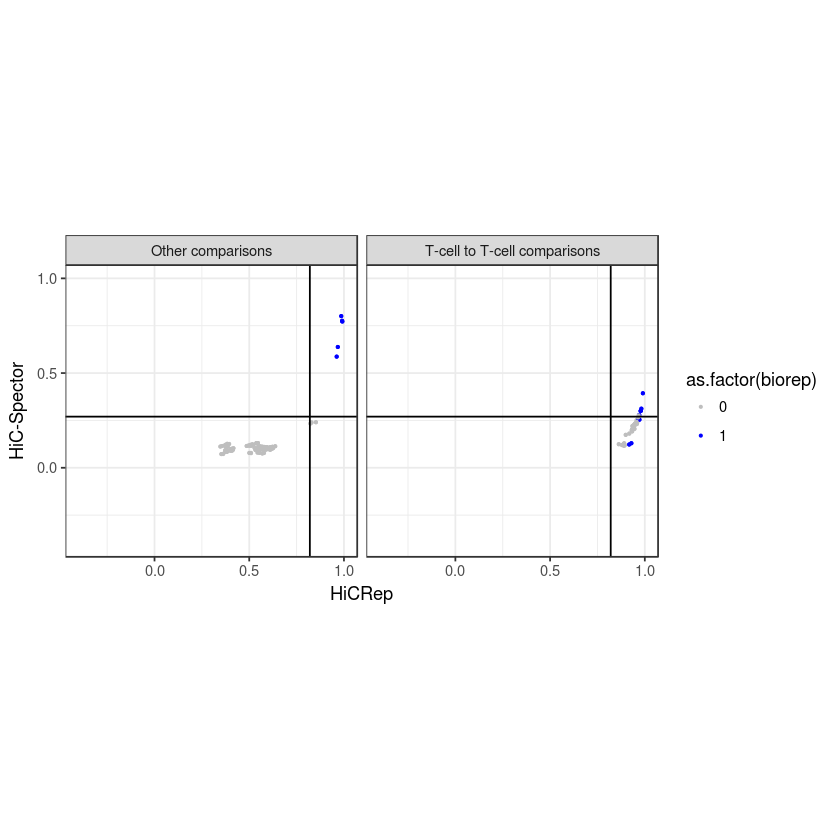

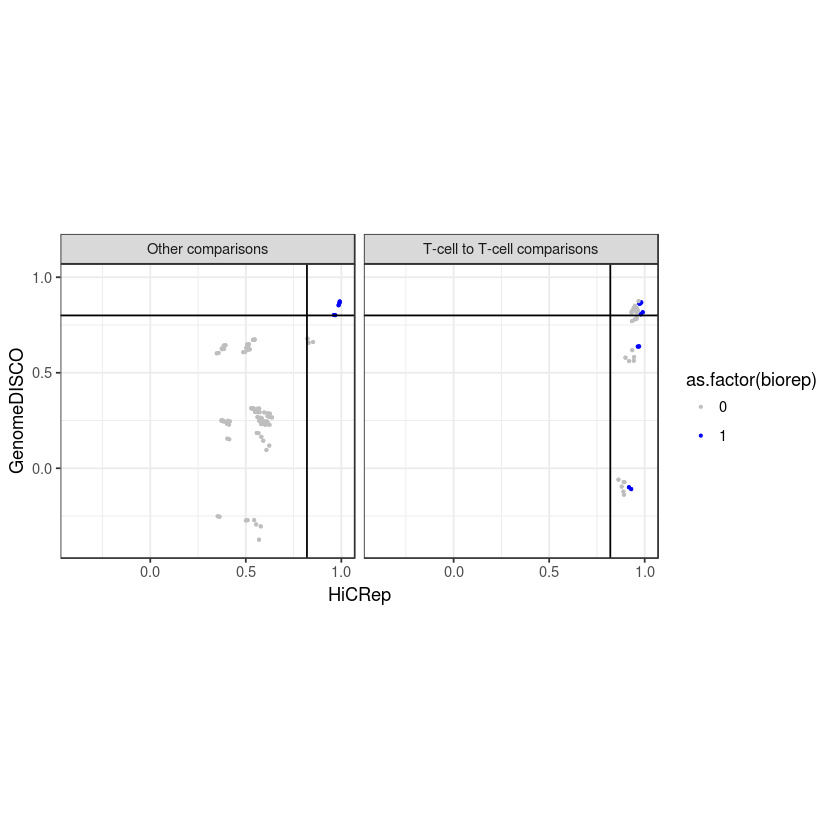

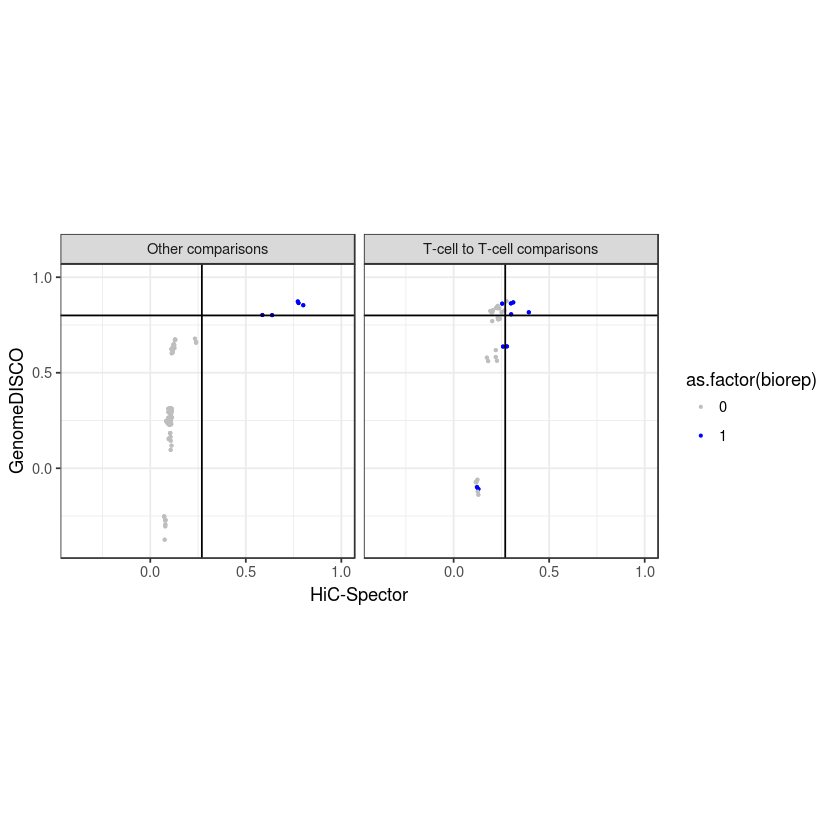

In [5]:
compare_2_scores=function(score1,score2,score1name,score2name,xt,yt,xmini,xmaxi,ymini,ymaxi,out){
    colnames(score1)[3]='score'
    colnames(score2)[3]='score'
    
    score1=annotate_celltype(score1)
    common=intersect(rownames(score1),rownames(score2))
    combined=data.frame(comparison=common,score1=score1[common,3],score2=score2[common,3],
                       biorep=score1[common,'biorep'],tcells=score1[common,'tcells'])
    p=ggplot(combined,aes(x=score1,y=score2,color=as.factor(biorep)))+
          geom_point(size=0.5)+theme_bw()+xlab(score1name)+ylab(score2name)+
         facet_wrap(~tcells)+geom_hline(yintercept = yt)+geom_vline(xintercept = xt)+
    scale_color_manual(values = c("gray","blue"))+coord_equal()+xlim(xmini,xmaxi)+ylim(ymini,ymaxi)
    pdf(out,width=7,height=3)
    print(p)
    dev.off()
    print(p)
}


compare_2_scores(allscores[,c('m1','m2','HiCRep')],allscores[,c('m1','m2','HiCSpector')],
                 'HiCRep','HiC-Spector',
                 HICREP_THRESHOLD,HICSPECTOR_THRESHOLD,
                 MIN_SCORE,MAX_SCORE,MIN_SCORE,MAX_SCORE,
                 paste(PLOTS_PATH,'/HiChIP.HiCRep_vs_HiC-Spector.pdf',sep=''))

compare_2_scores(allscores[,c('m1','m2','HiCRep')],allscores[,c('m1','m2','GenomeDISCO')],
                 'HiCRep','GenomeDISCO',
                 HICREP_THRESHOLD,GENOMEDISCO_THRESHOLD,
                 MIN_SCORE,MAX_SCORE,MIN_SCORE,MAX_SCORE,
                 paste(PLOTS_PATH,'/HiChIP.HiCRep_vs_GenomeDISCO.pdf',sep=''))

compare_2_scores(allscores[,c('m1','m2','HiCSpector')],allscores[,c('m1','m2','GenomeDISCO')],
                 'HiC-Spector','GenomeDISCO',
                 HICSPECTOR_THRESHOLD,GENOMEDISCO_THRESHOLD,
                 MIN_SCORE,MAX_SCORE,MIN_SCORE,MAX_SCORE,
                 paste(PLOTS_PATH,'/HiChIP.HiC-Spector_vs_GenomeDISCO.pdf',sep=''))